In [12]:
import glob
import pandas as pd
#訓練圖片目錄路徑
document = glob.glob("C:/Users/Big data/Desktop/pic_data/document/*.jpg")
graduation = glob.glob("C:/Users/Big data/Desktop/pic_data/graduation/*.jpg")
live = glob.glob("C:/Users/Big data/Desktop/pic_data/live/*.jpg")
noman = glob.glob("C:/Users/Big data/Desktop/pic_data/noman/*.jpg")
data = pd.DataFrame({
    "path": document+ graduation+ live+ noman,
    "ans": [0] * len(document) + [1] * len(graduation)+ [2] * len(live) + [3] * len(noman)
})
data

,path,ans
0,C:/Users/Big data/Desktop/pic_data/document\0 ...,0
1,C:/Users/Big data/Desktop/pic_data/document\0.jpg,0
2,C:/Users/Big data/Desktop/pic_data/document\00...,0
3,C:/Users/Big data/Desktop/pic_data/document\00...,0
4,C:/Users/Big data/Desktop/pic_data/document\00...,0
...,...,...
1441,C:/Users/Big data/Desktop/pic_data/noman\金門單程船...,3
1442,C:/Users/Big data/Desktop/pic_data/noman\長埤湖風景...,3
1443,C:/Users/Big data/Desktop/pic_data/noman\閃閃發光的...,3
1444,C:/Users/Big data/Desktop/pic_data/noman\香港花店_...,3


In [13]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
from keras.layers import Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
# Dense(256, activation="relu") -> 函式(e.g. return print)
# tensor = func(tensor)
for l in vgg.layers:
    l.trainable = False
# 1024:trainable 1024:non-trainable
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(4, activation="softmax")(x)
# Model(inputs=tensor, outputs=tensor)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
# trainable一定要在compile前就設定
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [16]:
from sklearn.model_selection import train_test_split
# !!! 進入訓練階段以後, list(X), dataframe(X) np.array(O)
import numpy as np
from keras.utils.np_utils import to_categorical
x = np.array(data["path"])
y = np.array(data["ans"])
y_cat = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y_cat, 
                                                    test_size=0.1)

In [17]:
# Pillow(PIL)
# 處理一張照片給你看
from keras.preprocessing.image import load_img
# 一定使用那個模型的preprocess
from keras.applications.vgg16 import preprocess_input
img = load_img(x_train[0], target_size=(224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[ -82.939   ,  -98.779   , -109.68    ],
        [ -82.939   ,  -98.779   , -109.68    ],
        [ -82.939   ,  -98.779   , -109.68    ],
        ...,
        [  31.060997,   14.221001,  -17.68    ],
        [  30.060997,   13.221001,  -18.68    ],
        [  31.060997,   14.221001,  -17.68    ]],

       [[ -82.939   ,  -98.779   , -109.68    ],
        [ -82.939   ,  -98.779   , -109.68    ],
        [ -82.939   ,  -98.779   , -109.68    ],
        ...,
        [  33.060997,   16.221   ,  -15.68    ],
        [  30.060997,   13.221001,  -18.68    ],
        [  32.060997,   15.221001,  -16.68    ]],

       [[ -82.939   ,  -98.779   , -109.68    ],
        [ -82.939   ,  -98.779   , -109.68    ],
        [ -82.939   ,  -98.779   , -109.68    ],
        ...,
        [  35.060997,   18.221   ,  -13.68    ],
        [  32.060997,   15.221001,  -16.68    ],
        [  30.060997,   13.221001,  -18.68    ]],

       ...,

       [[ -48.939003,  -62.779   ,  -83.68    ],
        [ -

In [20]:
# x:圖片, y:答案, batch:取幾個
# 回傳 (原始圖片[batch], 處理圖片[batch], 答案[batch])
def get_data(x, y, batch):
    idx = np.random.randint(0, x.shape[0], batch)
    # 原本未處理的圖片
    oriimgs = []
    # Preprocess過後的圖片
    preimgs = []
    for p in x[idx]:
        img = load_img(p, target_size=(224, 224)).convert("RGB")
        img_np = np.array(img)
        oriimgs.append(img_np)
        img_pre = preprocess_input(img_np) 
        preimgs.append(img_pre)

    oriimgs = np.array(oriimgs)
    preimgs = np.array(preimgs)
    ans = y[idx]
    return (oriimgs, preimgs, ans)

In [21]:
# 訓練: train_on_batch
# 驗證: test_on_batch
for i in range(10):
    print("次數:", i + 1)
    batch = 80
    train = get_data(x_train, y_train, batch)
    train_result = cnn.train_on_batch(train[1], train[2])
    print("[Train]:", train_result)
    # 如果可以把驗證的圖片設多一點
    test_batch = 20
    test = get_data(x_test, y_test, test_batch)
    test_result = cnn.test_on_batch(test[1], test[2])
    print("[Validate]:", test_result)
    print("-" * 30)

次數: 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[Train]: [1.8904941, 0.2]
[Validate]: [3.052298, 0.8]
------------------------------
次數: 2
[Train]: [4.710133, 0.5125]
[Validate]: [0.6541454, 0.65]
------------------------------
次數: 3
[Train]: [0.59641635, 0.85]
[Validate]: [1.7719128, 0.65]
------------------------------
次數: 4
[Train]: [1.3014375, 0.725]
[Validate]: [0.18838432, 0.95]
------------------------------
次數: 5
[Train]: [0.7994167, 0.875]
[Validate]: [0.21930969, 0.9]
------------------------------
次數: 6
[Train]: [0.69914085, 0.8875]
[Validate]: [0.079021685, 0.95]
------------------------------
次數: 7
[Train]: [0.6998569, 0.85]
[Validate]: [0.055378716, 1.0]
------------------------------
次數: 8
[Train]: [0.3212267, 0.9]
[Validate]: [0.1000119, 0.95]
------------------------------
次數: 9
[Train]: [0.65851784, 0.8625]
[Validate]: [0.121037185, 0.95]
------------------------------
次數: 10
[Train]: [0.8551518, 0.8875]
[Validate]: 

In [22]:
# 秀一下問題給你看
# 問題1: 怎麼全部同一個預測
# 問題2: 機率不該看到1 & 0
cnn.predict(test[1])

array([[8.7647300e-07, 4.2204751e-16, 9.9999917e-01, 4.7189436e-12],
       [3.9580419e-19, 2.0731681e-27, 1.0000000e+00, 9.0018003e-25],
       [2.9592423e-17, 1.5770752e-19, 1.0000000e+00, 1.7450741e-15],
       [8.6507535e-01, 6.3963697e-08, 1.3422157e-01, 7.0298434e-04],
       [1.2965634e-01, 1.0761807e-05, 3.4569436e-01, 5.2463847e-01],
       [9.9481636e-01, 9.2151839e-07, 5.0485516e-03, 1.3415459e-04],
       [1.2460677e-03, 9.7400224e-01, 4.3581072e-03, 2.0393629e-02],
       [9.9670773e-27, 1.0000000e+00, 4.4885464e-24, 2.7416116e-28],
       [0.0000000e+00, 1.0000000e+00, 2.6102805e-37, 0.0000000e+00],
       [3.0508442e-02, 1.9111446e-06, 3.2223675e-01, 6.4725292e-01],
       [2.7008111e-32, 1.0000000e+00, 1.7165323e-30, 4.6952603e-32],
       [3.7590237e-08, 3.4490411e-11, 1.9188408e-05, 9.9998081e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.4009888e-31, 0.0000000e+00, 8.4418076e-25, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+

In [23]:
final_batch = 50
final = get_data(x_test, y_test, final_batch)
pre = cnn.predict(final[1])
cnn.evaluate(final[1], final[2])

50/50 [==============================] - 5s 91ms/step


[0.15164041593670846, 0.96]

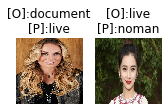

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model沒有predict_classes
# 所以我們要用argmax() 取得最大值的索引
# pre.argmax(axis=1)
idx = np.nonzero(pre.argmax(axis=1) != final[2].argmax(axis=1))[0]
# 預測錯誤的圖片
false_img = final[0][idx]
# 預測錯誤圖片的正確答案
false_answer = final[2].argmax(axis=1)[idx]
# 預測錯誤圖片的預測標籤
false_pre = pre.argmax(axis=1)[idx]

trans = ["document", "graduation", "live", "noman"]
width = 10
height = len(false_img) // width + 1
plt.figure(figsize=(14, 8))
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    t = "[O]:" + trans[false_answer[i]] + "\n[P]:" + trans[false_pre[i]]
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)


In [25]:
import pickle #pickle模組

#儲存Model(注:save資料夾要預先建立，否則會報錯)
with open('C:/Users/Big data/Desktop/pic_data/model/cnn.pickle', 'wb') as f:
    pickle.dump(cnn, f)

IndentationError: unexpected indent (<ipython-input-25-788d0cd25b40>, line 5)

In [20]:
#輸入圖片目錄路徑
TEST = glob.glob("C:/Users/Big data/Desktop/pic_data/test/*.jpg")
inimg = load_img(TEST[0], target_size=(224, 224)).convert("RGB")
img_np2 = np.array(inimg)
img_pre2 = preprocess_input(img_np2)
pre2imgs = []
pre2imgs.append(img_pre2)
pre2imgs = np.array(pre2imgs)
pre2imgs

pre = cnn.predict(pre2imgs)
pre

array([[0.0000000e+00, 4.8899876e-28, 6.0629688e-09, 1.0000000e+00]],
      dtype=float32)

In [21]:
#讀取Model
with open('C:/Users/Big data/Desktop/pic_data/model/cnn.pickle', 'rb') as f:
    cnn2 = pickle.load(f)
    

In [22]:
Finally = cnn2.predict(pre2imgs)
Finally

array([[0.0000000e+00, 4.8899876e-28, 6.0629688e-09, 1.0000000e+00]],
      dtype=float32)